In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import time
import os
import copy

In [ ]:
data_transforms = {
    'train': transforms.Compose([
                                 transforms.Resize((230,230)),
                                 transforms.RandomRotation(30,),
                                 transforms.RandomCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomVerticalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])                          
    ]),
    'valid': transforms.Compose([
                                 transforms.Resize((224,224)),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ])
}

In [ ]:
raw_dir = '/content/drive/MyDrive/flower_data'
train_data = datasets.ImageFolder(os.path.join(raw_dir, 'train'), data_transforms['train'])
val_data = datasets.ImageFolder(os.path.join(raw_dir, 'valid'), data_transforms['valid'])
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)
class_names = train_data.classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
      plt.title(title)
  plt.pause(0.001)

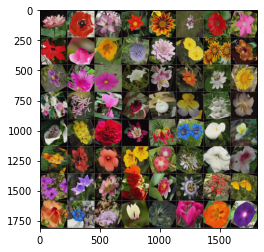

In [ ]:
inputs, classes = next(iter(train_dataloader))

out = torchvision.utils.make_grid(inputs)
imshow(out)

In [ ]:
model = models.resnext50_32x4d(pretrained=True)
num_features = model.fc.in_features
half_in_size = round(num_features/2)
layer_width = 102 #Small for Resnet, large for VGG
Num_class=102

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

In [ ]:
Multilayer_fc = nn.Sequential(
    nn.Linear(num_features, layer_width*2),
    nn.ReLU(inplace=True),
    nn.Linear(layer_width*2, layer_width*2),
    nn.ReLU(inplace=True),
    nn.Linear(layer_width*2, Num_class)
)
model.fc = Multilayer_fc

NameError: ignored

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()  # Set model to training mode
    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = loss_fn(outputs, labels)

            # backward + optimize
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / size
    epoch_acc = running_corrects.double() / size
    return epoch_loss, epoch_acc

In [ ]:
def validate(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  model.eval()
  running_loss = 0.0
  running_corrects = 0
  for inputs, labels in dataloader:
    inputs, labels = inputs.to(device), labels.to(device)
    pred = model(inputs)
    running_loss += loss_fn(pred, labels).item()
    running_corrects += (pred.argmax(1) == labels).type(torch.float).sum().item()
  epoch_loss = running_loss / size
  epoch_acc = running_corrects / size
  return epoch_loss, epoch_acc

In [ ]:
def train_model(model, loss_fn, optimizer, scheduler, epochs = 25):
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for t in range(epochs):
    print('Epoch {}/{}'.format(t, epochs-1))
    train_loss, train_acc = train(train_dataloader, model,loss_fn,optimizer)
    scheduler.step()
    print('{} Loss: {:.4f} Acc: {:.4f}'.format('train', train_loss, train_acc))
    val_loss, val_acc = validate(train_dataloader, model, loss_fn)
    print('{} Loss: {:.4f} Acc: {:.4f}'.format('test', val_loss, val_acc))
    if(val_acc> best_acc):
      best_acc = val_acc
      best_model_wts = copy.deepcopy(model.state_dict())
      time_elapsed = time.time() - since
      print('Time from Start {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))

    print()
  
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
  print('Best val Acc: {:4f}'.format(best_acc))
  model.load_state_dict(best_model_wts)
  return model


In [ ]:
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model_trained = train_model(model, loss_fn, optimizer, exp_lr_scheduler,
                       epochs=10)

Epoch 0/9


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 3.9607 Acc: 0.1558
test Loss: 0.0405 Acc: 0.4147
Time from Start 38m 8s

Epoch 1/9
train Loss: 1.4725 Acc: 0.6322
test Loss: 0.0118 Acc: 0.7897
Time from Start 41m 9s

Epoch 2/9
train Loss: 0.5515 Acc: 0.8503
test Loss: 0.0054 Acc: 0.8964
Time from Start 44m 10s

Epoch 3/9
train Loss: 0.2923 Acc: 0.9168
test Loss: 0.0059 Acc: 0.8980
Time from Start 47m 11s

Epoch 4/9
train Loss: 0.1820 Acc: 0.9493
test Loss: 0.0017 Acc: 0.9686
Time from Start 50m 12s

Epoch 5/9
train Loss: 0.1544 Acc: 0.9560
test Loss: 0.0013 Acc: 0.9753
Time from Start 53m 13s

Epoch 6/9
train Loss: 0.0964 Acc: 0.9727
test Loss: 0.0008 Acc: 0.9853
Time from Start 56m 13s

Epoch 7/9
train Loss: 0.0329 Acc: 0.9911
test Loss: 0.0002 Acc: 0.9980
Time from Start 59m 14s

Epoch 8/9
train Loss: 0.0212 Acc: 0.9954
test Loss: 0.0001 Acc: 0.9986
Time from Start 62m 16s

Epoch 9/9
train Loss: 0.0140 Acc: 0.9966
test Loss: 0.0001 Acc: 0.9992
Time from Start 65m 18s

Training complete in 65m 18s
Best val Acc: 0.999237


In [ ]:
torch.save(model_trained.state_dict(), "/content/drive/MyDrive/flower_data/best_model.pt")

In [ ]:
import json
name_json = "/content/drive/MyDrive/flower_data/cat_to_name.json"
with open(name_json, 'r') as f:
  cat_to_name = json.load(f)

In [ ]:
labels_map = {
    0:'1',
    1:'10',
    2:'100',
    3:'101',
    4:'102',
    5:'11',
    6:'12',
    7:'13',
    8:'14',
    9:'15',
    10:'16',
    11:'17',
    12:'18',
    13:"19",
    14:'2',
    15:'20',
    16:'21',
    17:'22',
    18:'23',
    19:'24',
    20:'25',
    21:'26',
    22:'27',
    23:'28',
    24:'29',
    25:'3',
    26:'30',
    27:'31',
    28:'32',
    29:'33',
    30:'34',
    31:'35',
    32:'36',
    33:'37',
    34:'38',
    35:'39',
    36:'4',
    37:'40',
    38:'41',
    39:'42',
    40:'43',
    41:'44',
    42:'45',
    43:'46',
    44:'47',
    45:'48',
    46:'49',
    47:'5',
    48:'50',
    49:'51',
    50:'52',
    51:'53',
    52:'54',
    53:'55',
    54:'56',
    55:'57',
    56:'58',
    57:'59',
    58:'6',
    59:'60',
    60:'61',
    61:'62',
    62:'63',
    63:'64',
    64:'65',
    65:'66',
    66:'67',
    67:'68',
    68:'69',
    69:'7',
    70:'70',
    71:'71',
    72:'72',
    73:'73',
    74:'74',
    75:'75',
    76:'76',
    77:'77',
    78:'78',
    79:'79',
    80:'8',
    81:'80',
    82:'81',
    83:'82',
    84:'83',
    85:'84',
    86:'85',
    87:'86',
    88:'87',
    89:'88',
    90:'89',
    91:'9',
    92:'90',
    93:'91',
    94:'92',
    95:'93',
    96:'94',
    97:'95',
    98:'96',
    99:'97',
    100:'98',
    101:'99',
}

In [ ]:
model_trained = torch.load('/content/drive/MyDrive/flower_data/best.pt')

In [ ]:
model_trained.eval()
x,y = val_data[57][0], val_data[57][1]
x= x.unsqueeze(0)
print(y)
with torch.no_grad():
  pred=model_trained(x)
  predicted, actual = cat_to_name[labels_map[pred[0].argmax(0).item()]], cat_to_name[labels_map[y]]
  print(f'Predicted: "{predicted}", Actual: "{actual}"')

10
Predicted: "globe-flower", Actual: "globe-flower"


In [ ]:
x=x.squeeze(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


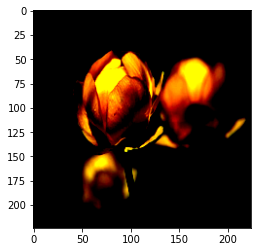

In [ ]:
plt.imshow(x.permute(1, 2, 0))

In [ ]:
print(val_data[0][1])

0
